# Khai Phá Và Tiền Xử Lý Dữ Liệu

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from PIL import Image
import random
import pandas as pd
from collections import Counter

## 1. Số lượng dữ liệu đã thu nhập được

In [14]:
# Đường dẫn tới dữ liệu đã phân chia
DATA_DIR = Path("data/splits")
CLASSES = ["Brown_Spot", "Leaf_Blast", "Leaf_Blight", "Healthy"]
SPLITS = ["train", "val", "test"]

# Đếm số lượng ảnh trong mỗi lớp và mỗi tập dữ liệu
counts = {}
for split in SPLITS:
    counts[split] = {}
    for cls in CLASSES:
        path = DATA_DIR / split / cls
        if path.exists():
            counts[split][cls] = len(list(path.glob("*")))
        else:
            counts[split][cls] = 0
            
df = pd.DataFrame(counts)
df["total"] = df.sum(axis=1)
df.loc["total"] = df.sum()
df

,train,val,test,total
Brown_Spot,876,176,198,1250
Leaf_Blast,868,189,193,1250
Leaf_Blight,890,171,189,1250
Healthy,871,185,194,1250
total,3505,721,774,5000


### 1.1 Trực Quan Hoá Số Lượng Dữ Liệu

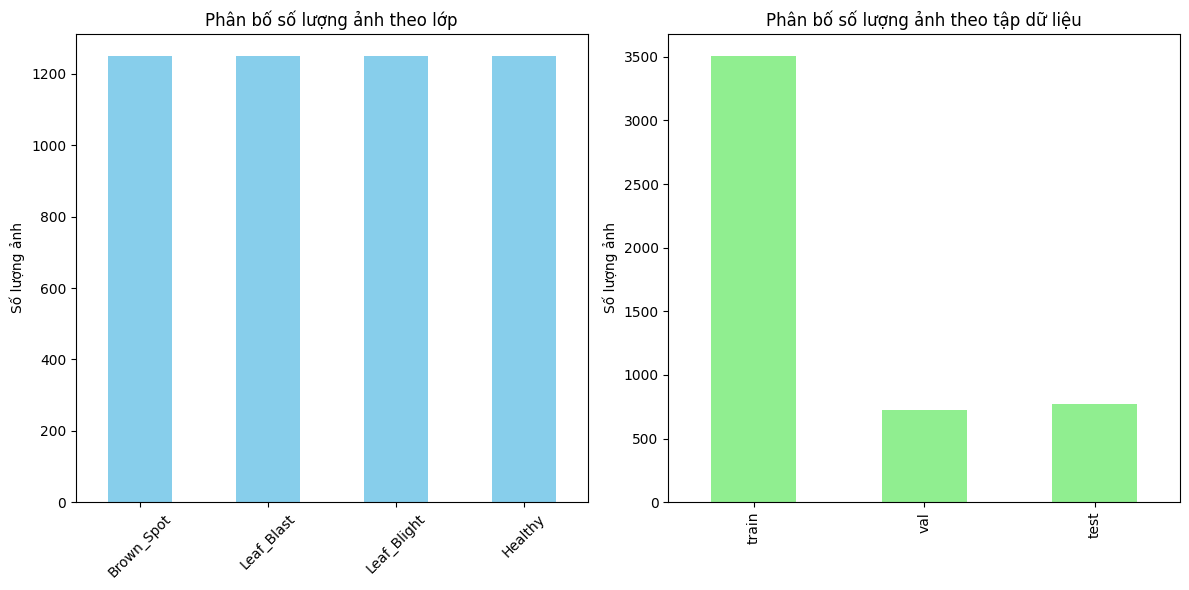

In [15]:
# Vẽ biểu đồ phân bố lớp và tập
plt.figure(figsize=(12, 6))

# Biểu đồ theo lớp
plt.subplot(1, 2, 1)
df.loc[CLASSES, "total"].plot(kind='bar', color='skyblue')
plt.title('Phân bố số lượng ảnh theo lớp')
plt.ylabel('Số lượng ảnh')
plt.xticks(rotation=45)

# Biểu đồ theo tập dữ liệu
plt.subplot(1, 2, 2)
df.loc["total", SPLITS].plot(kind='bar', color='lightgreen')
plt.title('Phân bố số lượng ảnh theo tập dữ liệu')
plt.ylabel('Số lượng ảnh')

plt.tight_layout()
plt.show()               
plt.savefig('image_distribution.png')
plt.close()

## 1.2 Phân tích các thuộc tính của ảnh

In [16]:
# Phân tích các thuộc tính của ảnh: kích thước, kênh màu, độ sáng
sizes = []
aspect_ratios = []
brightness_values = []
class_data = {cls: {"sizes": [], "brightness": []} for cls in CLASSES}

# Lấy mẫu ngẫu nhiên từ tập train
samples = []
for cls in CLASSES:
    path = DATA_DIR / "train" / cls
    if path.exists():
        files = list(path.glob("*"))
        # Lấy tối đa 100 ảnh mỗi lớp để phân tích
        samples.extend(random.sample(files, min(100, len(files))))

for img_path in samples:
    try:
        # Đọc ảnh bằng OpenCV để phân tích
        img = cv2.imread(str(img_path))
        if img is None:
            continue

        # Lấy thông tin kích thước
        h, w, c = img.shape
        sizes.append((w, h))
        aspect_ratios.append(w / h)

        # Tính độ sáng trung bình
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        brightness = np.mean(hsv[:, :, 2])
        brightness_values.append(brightness)

        # Lưu thông tin theo lớp
        cls = img_path.parent.name
        if cls in class_data:
            class_data[cls]["sizes"].append((w, h))
            class_data[cls]["brightness"].append(brightness)

    except Exception as e:
        print(f"Lỗi khi xử lý {img_path}: {e}")

# Phân tích kích thước
widths, heights = zip(*sizes)
print("\n===== PHÂN TÍCH KÍCH THƯỚC ẢNH =====")
print(f"Kích thước trung bình: {np.mean(widths):.1f} x {np.mean(heights):.1f}")
print(f"Kích thước nhỏ nhất: {min(widths)} x {min(heights)}")
print(f"Kích thước lớn nhất: {max(widths)} x {max(heights)}")
print(f"Tỷ lệ khung hình trung bình: {np.mean(aspect_ratios):.2f}")


===== PHÂN TÍCH KÍCH THƯỚC ẢNH =====
Kích thước trung bình: 241.0 x 241.0
Kích thước nhỏ nhất: 64 x 64
Kích thước lớn nhất: 300 x 300
Tỷ lệ khung hình trung bình: 1.00


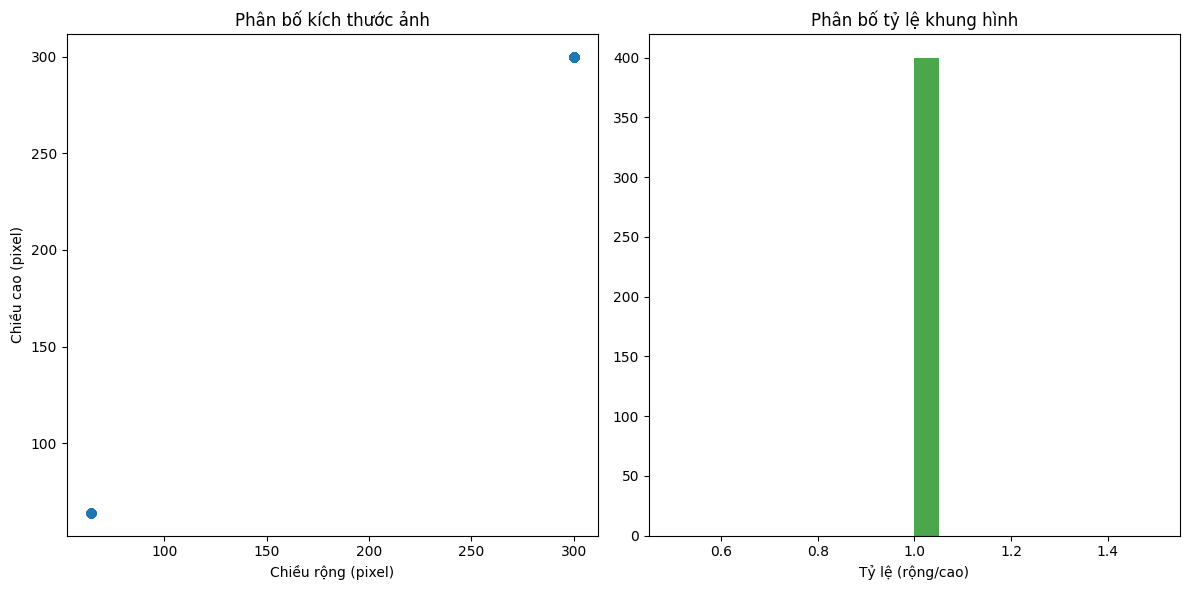

In [17]:
# Vẽ biểu đồ phân bố kích thước
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(widths, heights, alpha=0.5)
plt.title('Phân bố kích thước ảnh')
plt.xlabel('Chiều rộng (pixel)')
plt.ylabel('Chiều cao (pixel)')

plt.subplot(1, 2, 2)
plt.hist(aspect_ratios, bins=20, color='green', alpha=0.7)
plt.title('Phân bố tỷ lệ khung hình')
plt.xlabel('Tỷ lệ (rộng/cao)')
plt.tight_layout()
plt.show()
plt.savefig('image_sizes.png')
plt.close()

/tmp/ipykernel_156709/216695344.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=CLASSES)


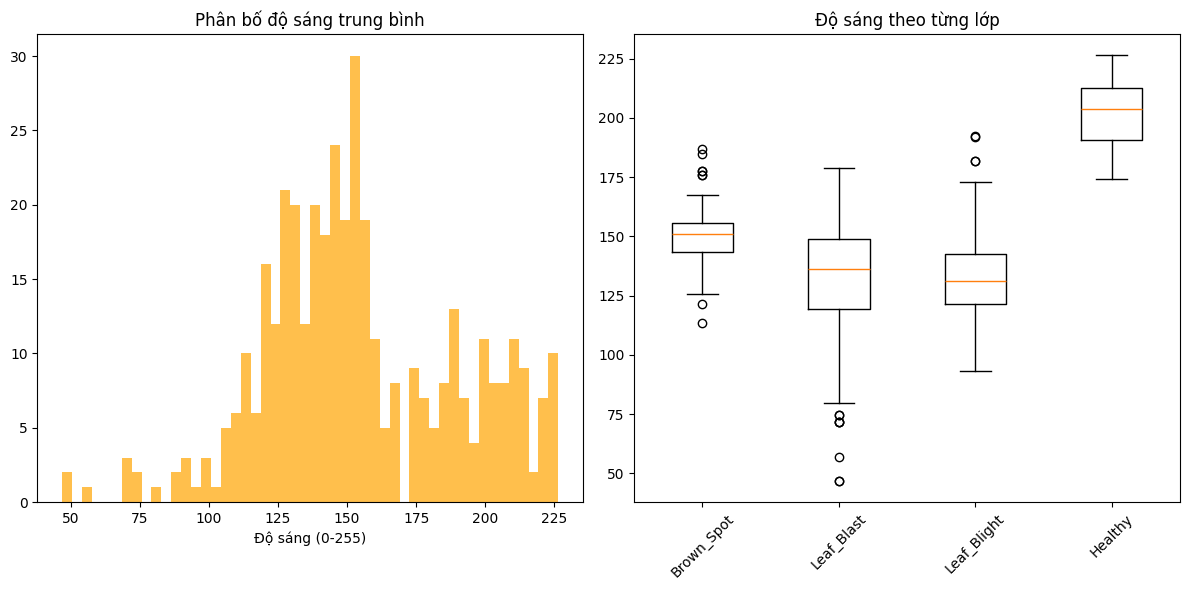

In [18]:
# Vẽ biểu đồ phân bố độ sáng
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(brightness_values, bins=50, color='orange', alpha=0.7)
plt.title('Phân bố độ sáng trung bình')
plt.xlabel('Độ sáng (0-255)')

plt.subplot(1, 2, 2)
boxplot_data = [class_data[cls]["brightness"] for cls in CLASSES]
plt.boxplot(boxplot_data, labels=CLASSES)
plt.title('Độ sáng theo từng lớp')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('image_brightness.png')
plt.close()

## 1.3 Hiển thị một số mẫu từ mỗi lớp

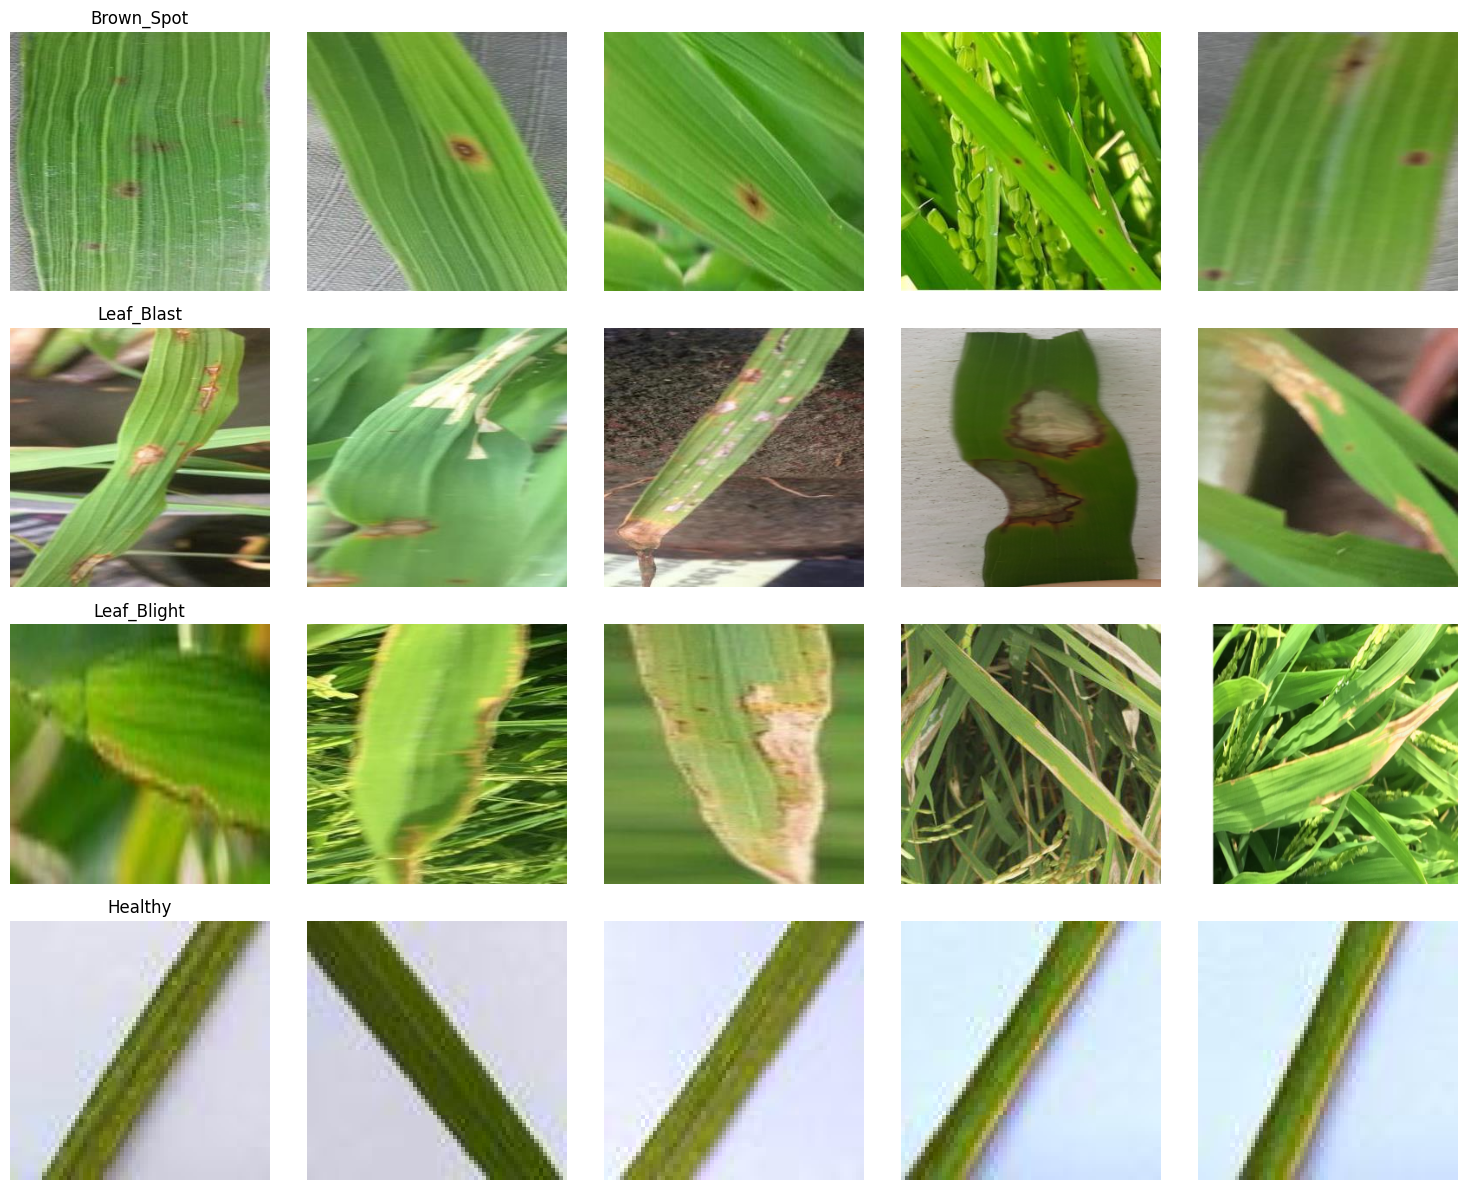

In [ ]:
def visualize_samples():
    
    plt.figure(figsize=(15, 12))
    for i, cls in enumerate(CLASSES):
        path = DATA_DIR / "train" / cls
        if path.exists():
            files = list(path.glob("*"))
            # Lấy 5 ảnh mẫu mỗi lớp
            samples = random.sample(files, min(5, len(files)))
            
            for j, img_path in enumerate(samples):
                try:
                    img = Image.open(img_path)
                    plt.subplot(len(CLASSES), 5, i*5 + j + 1)
                    plt.imshow(img)
                    plt.axis('off')
                    if j == 0:
                        plt.title(cls)
                except Exception as e:
                    print(f"Lỗi khi hiển thị {img_path}: {e}")
    
    plt.tight_layout()
    plt.show()
    plt.savefig('sample_images.png')
    plt.close()
    
def main():
    visualize_samples()

if __name__ == "__main__":
    main()